# CREDIT ANALYSIS PROJECT


## This Project has the purporse to analyse customers who want to apply for a loan.

## The goal is to predict who can or not receive a loan. 


# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

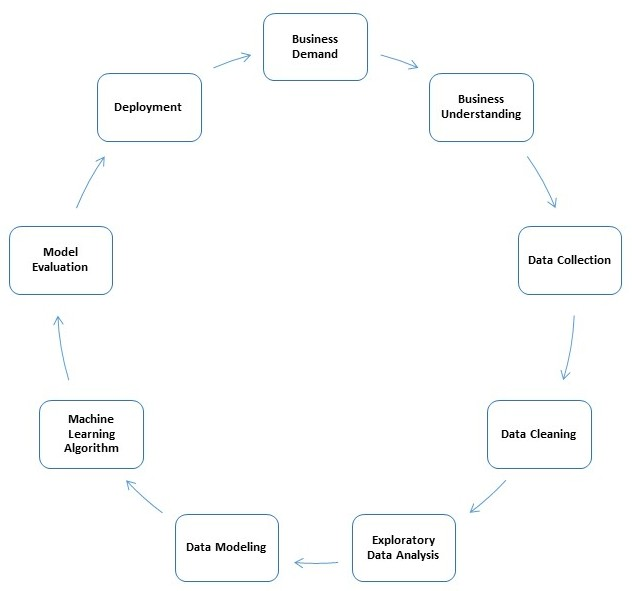

In [123]:
Image("img/crisp1.jpg")

# 0.0 IMPORTS

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle

from IPython.display       import Image
from scipy                 import stats as ss
from datetime              import timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute        import  SimpleImputer
from IPython.core.display  import HTML
from boruta                import BorutaPy

# warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [125]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )
def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Loading data and check data types

In [126]:
# load data
df0 = pd.read_csv('data/credit_data.csv')

dtypes = df0.dtypes
colnames = dtypes.index
dtypes_list = [i.name for i in dtypes.values] # transform in a list

# create datatypes dictionary
dict_column_types = dict(zip(colnames, dtypes_list))

print('{}\n\n{}'.format(df0.info(), dict_column_types ))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   int64  
 1   income      2000 non-null   float64
 2   age         1997 non-null   float64
 3   loan        2000 non-null   float64
 4   c#default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB
None

{'i#clientid': 'int64', 'income': 'float64', 'age': 'float64', 'loan': 'float64', 'c#default': 'int64'}


In [127]:
# show statistics to determine data types
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
i#clientid,2000.0,1000.500000,577.494589,1.00000,500.750000,1000.500000,1500.250000,2000.000000
income,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
age,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
loan,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
c#default,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


## 0.3 Change Data Types

### for better performance is necessary to set data types correctly.

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

- bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

In [128]:
# Load full data with optimized datatypes

df0 = pd.read_csv('data/credit_data.csv', dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float16', 'loan': 'float16','c#default': 'uint8'} )
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   i#clientid  2000 non-null   uint16 
 1   income      2000 non-null   float32
 2   age         1997 non-null   float16
 3   loan        2000 non-null   float16
 4   c#default   2000 non-null   uint8  
dtypes: float16(2), float32(1), uint16(1), uint8(1)
memory usage: 21.6 KB


# 1.0 DATA PREPROCESSING

In [375]:
df1 = df0.copy()

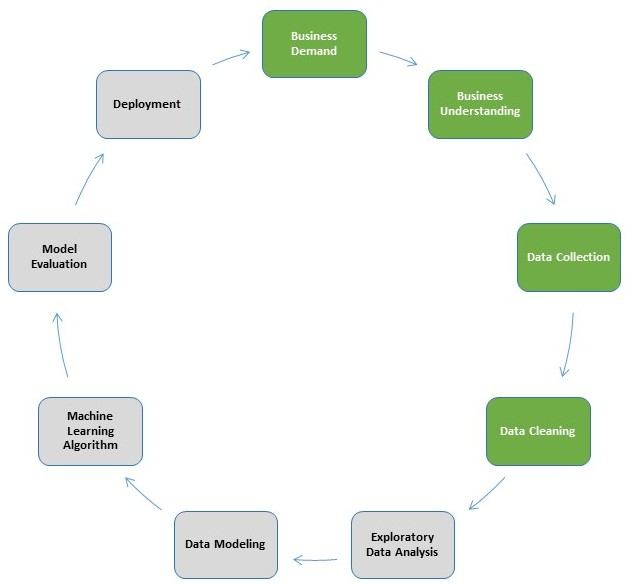

In [130]:
Image("img/crisp3.jpg")

## 1.1 Data Dimensions

In [131]:
df_shape = df1.shape
print('Number of rows: {}\nNumber of Cols: {}'.format(df_shape[0], df_shape[1]))

Number of rows: 2000
Number of Cols: 5


## 1.2 Detecting missing values

In [132]:
# check "not available" values
df1.isna().sum()

i#clientid    0
income        0
age           3
loan          0
c#default     0
dtype: int64

## 1.2 Fillout missing values

In [133]:
# filtering only missing values from age
df1[pd.isnull(df1["age"])]
df1[df1['income']<20000]


,i#clientid,income,age,loan,c#default


In [378]:
# fillout missing values

# Create object SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')

# apply SimpleImputer
si.fit(X=df1)

# reconstruct new dataframe with imputed set
df2 = pd.DataFrame.from_records(
    data=si.transform(
        X=df1
    ),  # SimpleImputer.transform(<<pandas dataframe>>) result is a list of lists
    columns=df1.columns  # keep originals columns
).astype(dtype={'i#clientid': 'uint16', 'income': 'float32', 'age': 'float16', 'loan': 'float16','c#default': 'uint8'})

## 1.3 Treating negative ages

In [380]:
# get mean age>0
age_mean = df2['age'][df2.age>0].mean()

# applying mean to negative ages
df2.loc[df2.age < 0, 'age'] = age_mean

# 2.0 DATA DESCRIPTIONS

In [381]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

## 2.1 Numerical Attributes Statistics

In [382]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,i#clientid,1.000000,2000.0000,1.999000e+03,1.000500e+03,1000.500000,5.773502e+02,0.000000,-1.200000
1,income,20014.490234,69995.6875,4.998120e+04,4.533160e+04,45789.117188,1.432275e+04,-0.042621,-1.201707
2,age,18.062500,inf,inf,inf,41.375000,NaN,NaN,NaN
3,loan,1.377930,13768.0000,1.376800e+04,inf,3976.000000,inf,NaN,NaN
4,c#default,0.000000,1.0000,1.000000e+00,1.415000e-01,0.000000,3.485366e-01,2.058717,2.240556


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OverflowError: cannot convert float infinity to integer

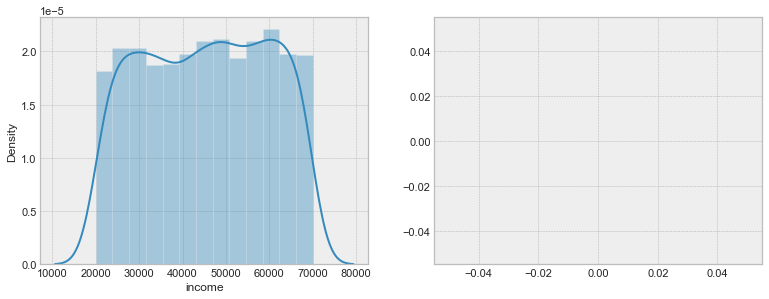

In [383]:
# mount grid 3 rows x 3 cols to receive charts
grid = GridSpec(2, 3)

# Distribution
plt.subplot(grid[0,0])
sns.distplot( df2['income'] )

plt.subplot(grid[0,1])
sns.distplot( df2['age'] )

plt.subplot(grid[0,2])
sns.distplot( df2['loan'] )

# Boxplot
plt.subplot(grid[1,0])
sns.boxplot( x=df2['income'])

plt.subplot(grid[1,1])
sns.boxplot( x=df2['age'] )

plt.subplot(grid[1,2])
sns.boxplot( x=df2['loan'] )

## 2.2 Analysing chart above

#### - We have outliers in the loans.

#### - We have great loans volume below $ 5.000

#### - 75% os loans area less than $ 6.000.

#### - 25% of customers are under 30 years

#### - 50% of customers incomes are over $ 40.000

# 3.0 FEATURE ENGINEERING

In [ ]:
df3 = df2.copy()

## 3.1 Mind Map - Which leverages impact the granting of credit

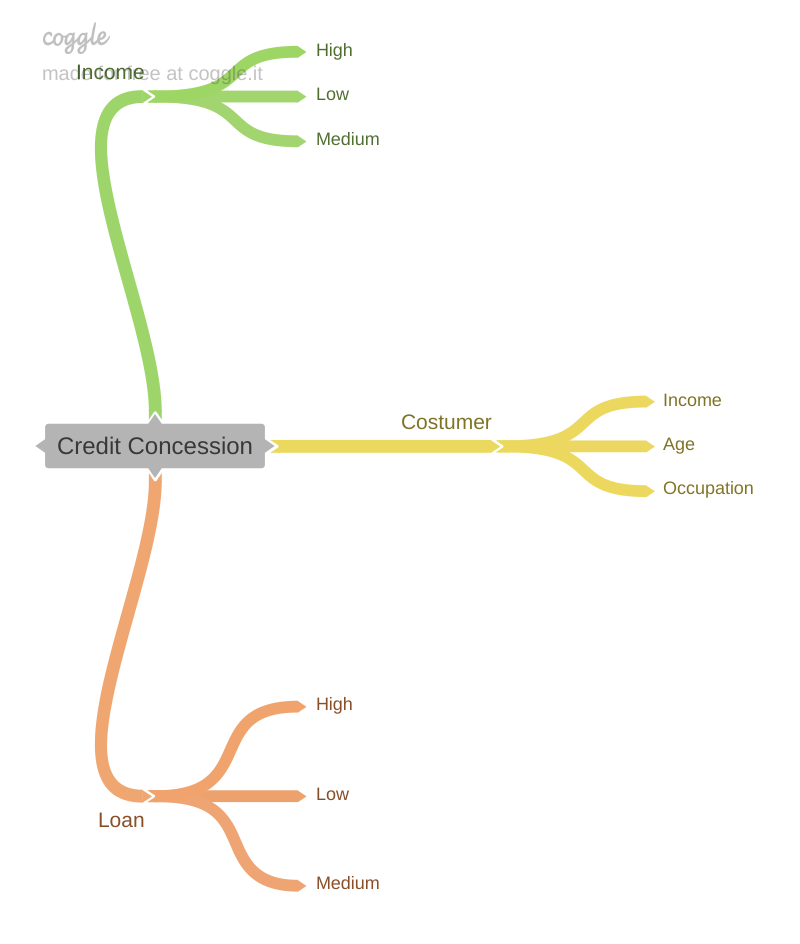

In [384]:
Image("img/Credit_Concession.png")

## 3.2 - Creating Hypotheses to get insigths

### 3.2.1 - Loan Assumptions

**1.** High loan values are more denied.

**2.** Mid Loan are more granted.

**3.** Loans are more applyed in the begining of the year. 

### 3.2.1 - Customers Assumptions

**1.** High age customers apply for more loans.

**2.** Young customers apply for lower loans.

**3.** Mid age customers apply for high loans.

**4.** Customers with higher level of studies apply less loans.

### 3.2.1 - Income Assumptions

**1.** Low income apply for more loans.

**2.** High income apply for high loans values.

**3.** Low income are more denied.

### 3.2.1 - Hypotheses Final List

**1.** High Loan are mode denied.

**2.** Median Loan are more granted.

**3.** High age customers apply for more loans.

**4.** Young customers apply for lower loans.

**5.** Mid age customers apply for high loans.

**6.** Low income apply for more loans.

**7.** High income apply for high loans values.

**8.** Low income are more denied.

## 3.3 - Feature Engineering

In [385]:
# Income
df3['income_type'] = df3['income'].apply(lambda x: 'low' if x<35000 else 'mid' if (x>=35000) & (x<50000) else 'high' )

# Age
df3['age_type'] = df3['age'].apply(lambda x: 'young' if x<=30 else 'mid' if (x>30) & (x<60) else 'high' )

# loan
df3['loan_type'] = df3['loan'].apply(lambda x: 'low' if x<=2000 else 'mid' if (x>2000) & (x<6000) else 'high' )

# 4.0 EXPLORATORY DATA ANALYSIS

In [386]:
df4 = df3.copy()

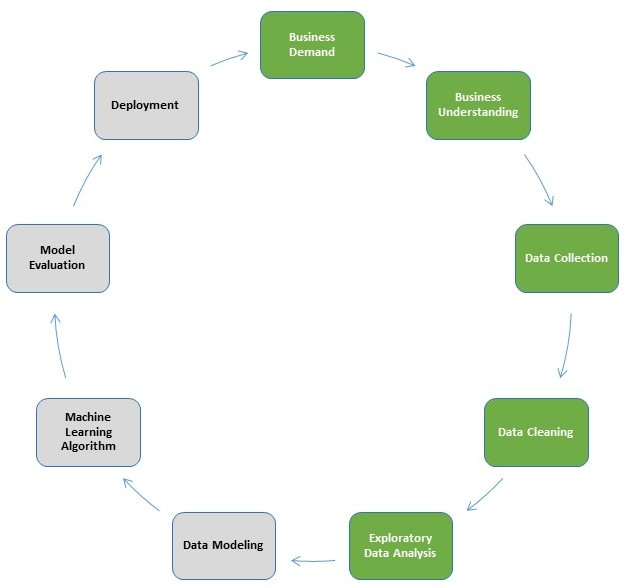

In [387]:
Image("img/crisp4.jpg")

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='c#default', ylabel='Density'>

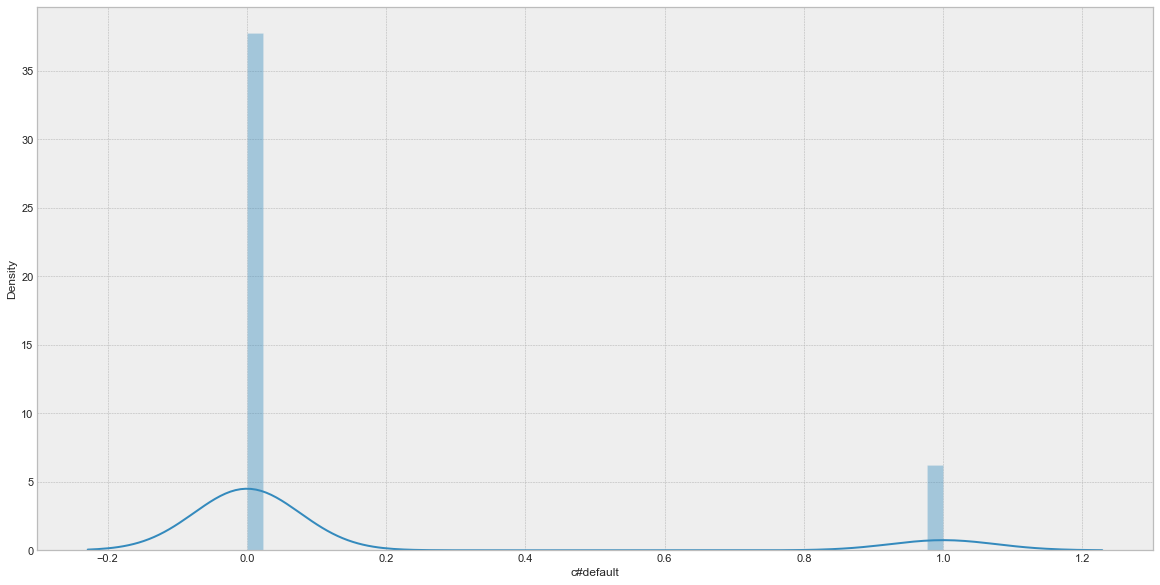

In [388]:
sns.distplot(df4['c#default'])

### 4.1.2 Analysing chart above

#### - We have an unbalanced dataset. We have to balanced the dataset, using undersamplig or oversampling techniques, to get a better model.

### 4.1.3 Numerical Variable

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

ValueError: supplied range of [18.0625, inf] is not finite

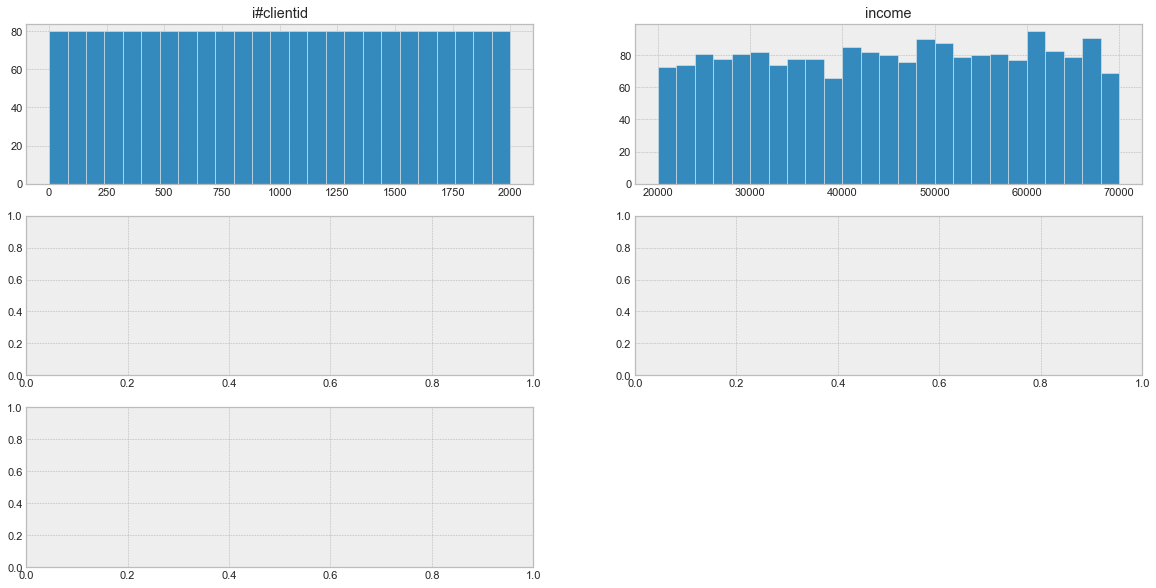

In [389]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [ ]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(df4['income_type'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['income_type'] == 'low']['loan'], label='low', shade=True) 
sns.kdeplot(df4[df4['income_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['income_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

# age
plt.subplot(3, 2, 3)
sns.countplot(df4['age_type'])
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['age_type'] == 'young']['loan'], label='young', shade=True) 
sns.kdeplot(df4[df4['age_type'] == 'mid']['loan'], label='mid', shade=True)
sns.kdeplot(df4[df4['age_type'] == 'high']['loan'], label='high', shade=True)
plt.legend()

#loan
plt.subplot(3, 2, 5)
sns.countplot(df4['loan_type'])
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['loan_type'] == 'low']['loan'], label='low', shade=True, legend=True) 
sns.kdeplot(df4[df4['loan_type'] == 'mid']['loan'], label='mid', shade=True, legend=True)
sns.kdeplot(df4[df4['loan_type'] == 'high']['loan'], label='high', shade=True, legend=True)
plt.legend()

### 4.2 Statistics above

### - Low income loan maximum is $ 7.000

### - High income loan is in a large range of values, fom low to high values.

### - Loan types range is great to cluster customers classes.

## 4.2 Bivariate Analysis

### H1 - High loan values are more denied.

**False**, mid loans is more denied.

In [ ]:
aux = df4[df4['c#default']==0]
aux_corr = aux[['income', 'loan']]
aux_agg = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_agg).set_title('Loans count by type')

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');

### H2 - Median Loan are more granted

**False**, High values are more granted.

In [ ]:
aux = df4[df4['c#default']==1]
aux_corr = aux[['income', 'loan']]
aux_loan_type = aux[['loan_type']].groupby('loan_type').size().to_frame('count').reset_index()

# loan types
plt.subplot(1, 3, 1)
sns.barplot(x='loan_type', y='count', data=aux_loan_type).set_title('Income x Loan distribution');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Income x Loan Pearson correlation');


### H3 - High age customers apply for more loans.

**False**, mid age apply for more loans.

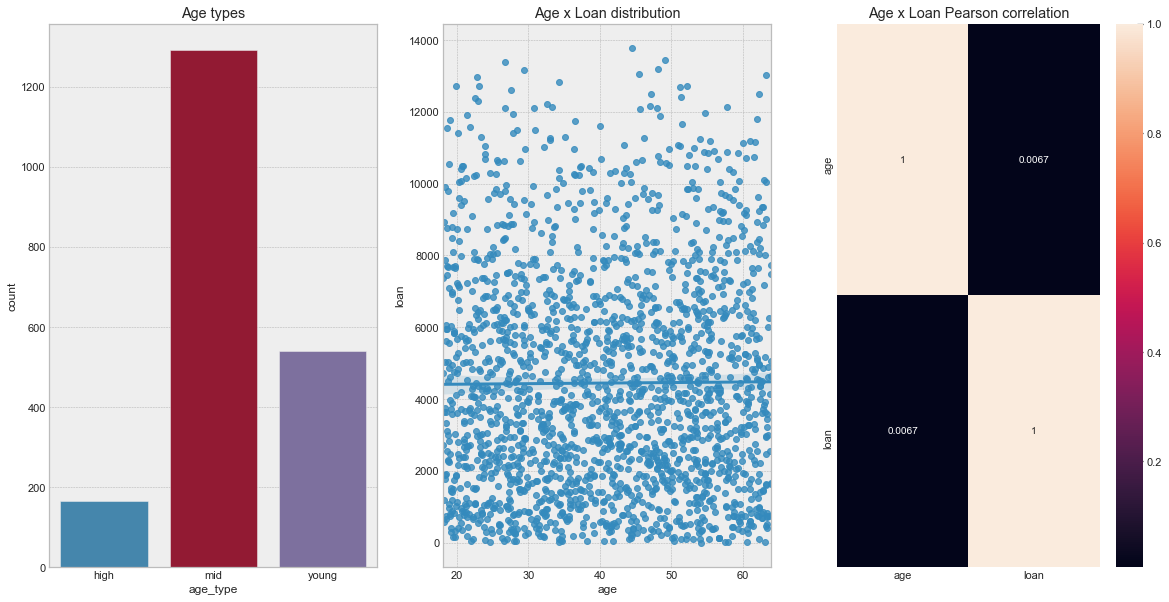

In [390]:
aux = df4[['age_type']].groupby('age_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_age).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H4 - Young customers apply for lower loans.

**False**, mid age customers apply for lower loans.

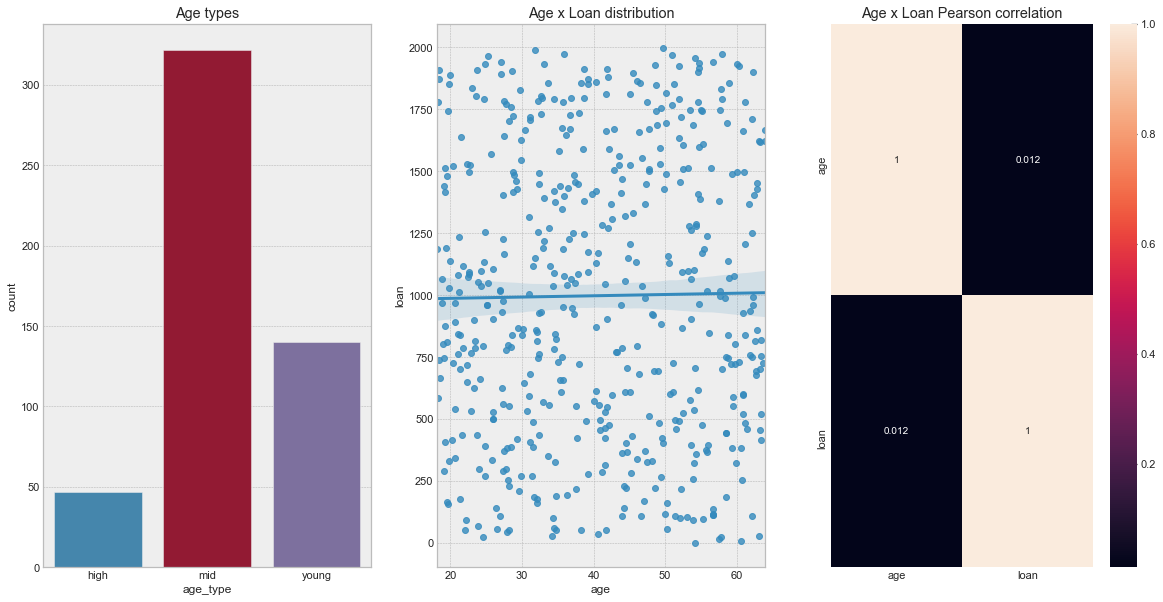

In [391]:
aux = df4[df4['loan_type']=='low']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H5 - Mid age customers apply for high loans..

**True**, mid age customers apply for high loans.

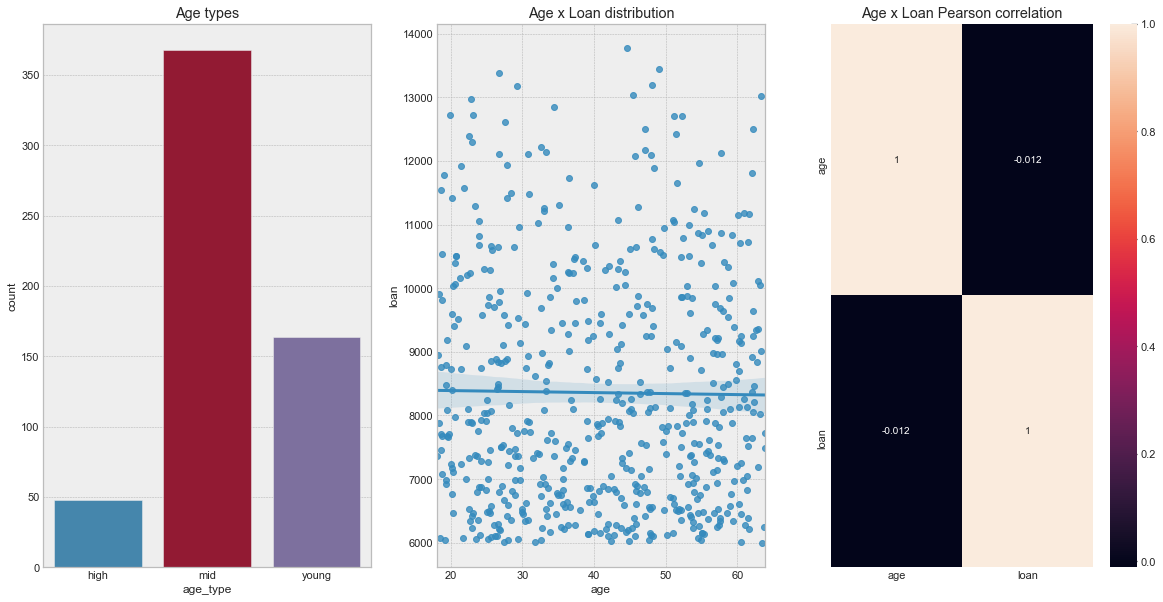

In [392]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['age_type']].groupby(['age_type']).size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='age_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H6 - Low income apply for more loans.

**False**, high income apply for more loans.

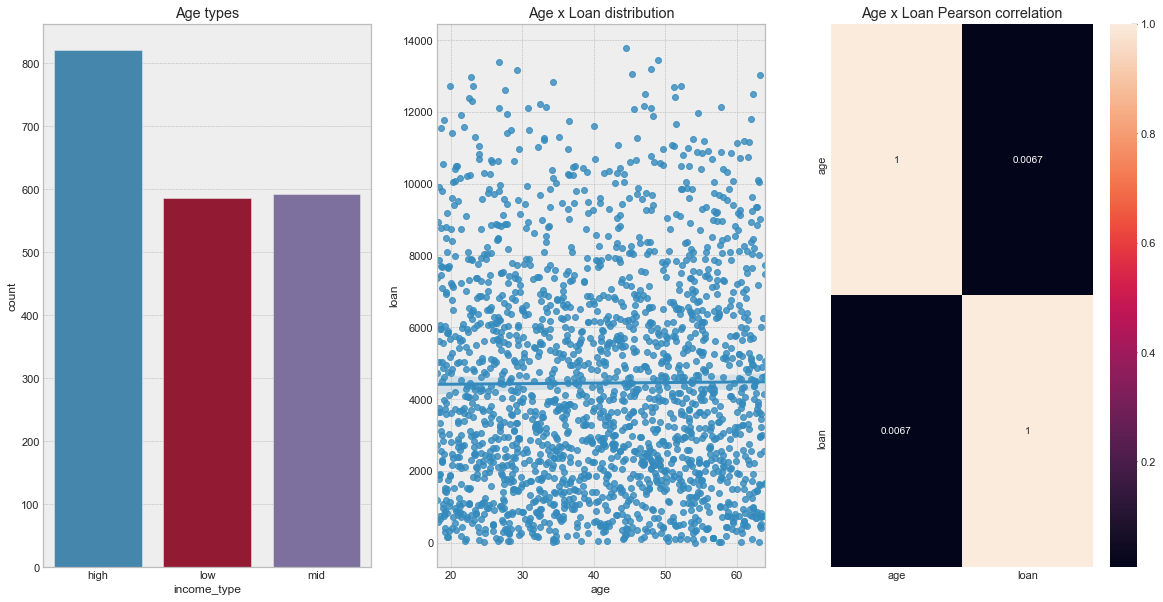

In [393]:
aux = df4[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = df4[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H7 - High income apply for high loans values.

**True**, high income apply for high loans values.

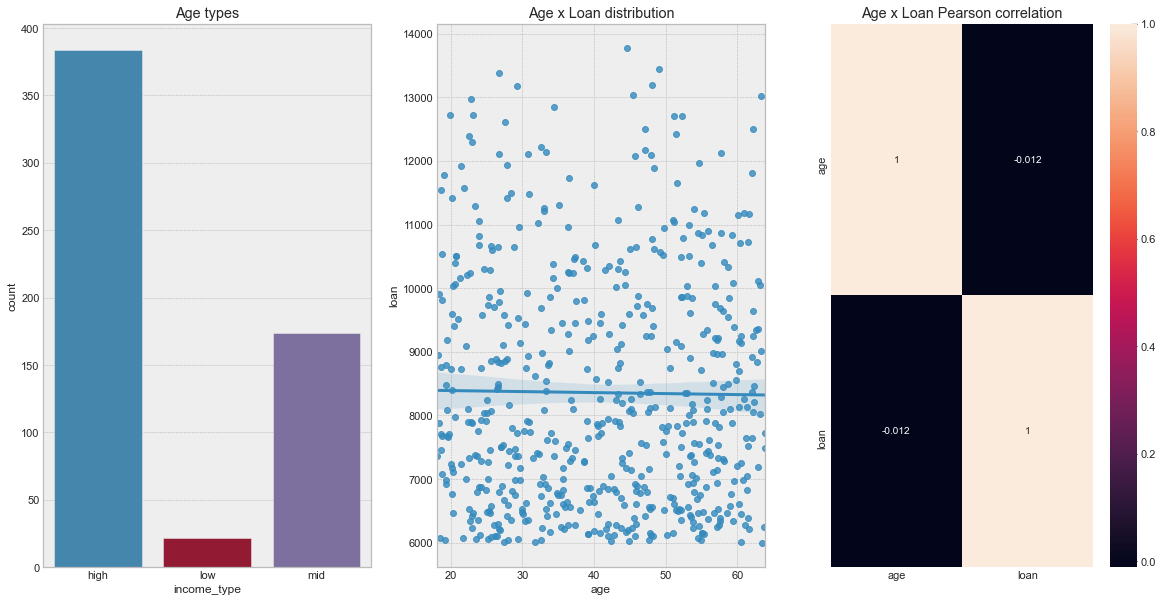

In [394]:
aux = df4[df4['loan_type']=='high']
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


### H8 - Low income are mode denied.

**False**, high incomes are more denied.

In [396]:
df4.dtypes

i#clientid     float64
income         float64
age            float64
loan           float64
c#default      float64
income_type     object
age_type        object
loan_type       object
dtype: object

In [364]:
aux = df4[df4['c#default']=='0']
aux.head()
aux_agg = aux[['income_type']].groupby('income_type').size().to_frame('count').reset_index()
aux_corr = aux[['age', 'loan']]
aux_agg.head()

# age types
plt.subplot(1, 3, 1)
sns.barplot(x='income_type', y='count', data=aux_agg).set_title('Age types');

# loan values denied distribution
plt.subplot(1, 3, 2)
#sns.scatterplot( x='income', y='loan', data=aux).set_title('Income x Loan distribution')
sns.regplot( x='age', y='loan', data=aux_corr).set_title('Age x Loan distribution');

# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('Age x Loan Pearson correlation');


,i#clientid,income,age,loan,c#default,income_type,age_type,loan_type


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

## 4.1 Multivariate Analysis

# 5.0 DATA PREPARATION



# 6.0 FEATURE SELECTION

# 7.0 MACHINE LEARNING MODELLING

In [ ]:
# 0.0 IMPORTS